In [1]:
from collector_factory import CollectorFactory
from writer_factory import WriterFactory
import numpy as np
import pandas as pd
import os
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

c:\Users\Susana\anaconda3\envs\aa1\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### 1. Collect and write data

In [ ]:
collector = CollectorFactory.initialize_collector('APIncbi')
writer = WriterFactory.initialize_writer('FileWriter')
writer.set_path('./data')
list = []
n = 10000
for seq_object in collector.collect(n):
    writer.write(seq_object[0], str(seq_object[1]))
    list.append(seq_object[1])

In [3]:
unique_values = set(list)
print(len(unique_values))

3562


### 2.1 Encoding the data with One-Hot

In [4]:
aminoacids = 'ACDEFGHIKLMNPQRSTVWYXBJU'
amino_dict = {amino: idx for idx, amino in enumerate(aminoacids)}

def one_hot_encode(secuencia, max_length):
    encoding = np.zeros((max_length, len(aminoacids)))
    
    for i, amino in enumerate(secuencia):
        if amino not in amino_dict:
            print("Unrecognized amino acid:", amino)
        else:
            encoding[i, amino_dict[amino]] = 1
    return encoding.flatten()

data = []

for file in os.listdir('./data'):
    with open(os.path.join('./data', file), 'r') as f:
        seq = f.read().strip()
        data.append({'filename': file, 'sequence': seq})

max_length = max(len(record['sequence']) for record in data)

for record in data:
    encoded_seq = one_hot_encode(record['sequence'], max_length)
    record['encoded_sequence'] = encoded_seq

df = pd.DataFrame(data)

display(df.head())

,filename,sequence,encoded_sequence
0,aab01987.1.bio,MRLLAKIICLMLWAICVAE,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,aab93671.1.bio,LNRVVGGEDSTDSEWPWIVSIQKNGTHHCAGSLLTSRWVITAAHCF...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,aac04477.1.bio,PPALAMPMPTEGTPPPLSGTPIPVPAYFRHAEPGFSLKRPRGLSRS...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,aac08447.1.bio,MGITGNTSPFGQPFSQAGGQPMGATGVNPQLASKQSMVNSLPTFPT...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,aac08452.1.bio,DDQLLDDGKTLGECGFTSQTARPQAPATVGLAFRADDTFEALCIEP...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### 2.2. Encoding the data  by Physicochemical Properties

In [9]:
# IMPRIMIR EL ENCODED_SEQ de la fila 0
len(df['encoded_sequence'][0])


122904

### 2.1. Encoding the data a variation of bag of words

In [30]:
def alpha(i, n):
    return (n - i) * 1 / n

aminoacids = list('ACDEFGHIKLMNPQRSTVWYXBJU')
dict_amino = {amino: idx for idx, amino in enumerate(aminoacids)}


def get_vector(seq, alpha,n):
    v = np.zeros(len(aminoacids)) 
    for i in range(len(seq)):
        pos = dict_amino[seq[i]]
        v[pos] += 1 * alpha(i, n)
    return v

def get_vector_individual(seq, alpha):
    n = len(seq)
    v = np.zeros(len(aminoacids)) 
    for i in range(len(seq)):
        pos = dict_amino[seq[i]]
        v[pos] += 1 * alpha(i, n)
    return v

In [33]:
display(df.head())

,filename,sequence,encoded_sequence,vector,vector_individual
0,aab01987.1.bio,MRLLAKIICLMLWAICVAE,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.9933606717438, 1.9955086897090413, 0.0, 0.9...","[1.2105263157894735, 0.7894736842105263, 0.0, ..."
1,aab93671.1.bio,LNRVVGGEDSTDSEWPWIVSIQKNGTHHCAGSLLTSRWVITAAHCF...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[21.292325717633283, 9.734817418472954, 10.739...","[8.62730627306273, 4.988929889298892, 6.070110..."
2,aac04477.1.bio,PPALAMPMPTEGTPPPLSGTPIPVPAYFRHAEPGFSLKRPRGLSRS...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[37.941027143136104, 9.440538957234915, 16.827...","[18.698989898989897, 4.212121212121212, 5.8666..."
3,aac08447.1.bio,MGITGNTSPFGQPFSQAGGQPMGATGVNPQLASKQSMVNSLPTFPT...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[43.38527631322007, 8.761960554579183, 11.4090...","[21.873873873873872, 6.8036036036036025, 6.547..."
4,aac08452.1.bio,DDQLLDDGKTLGECGFTSQTARPQAPATVGLAFRADDTFEALCIEP...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.939660222612771, 1.9892599101737942, 7.9615...","[3.7083333333333335, 1.2361111111111112, 5.263..."


In [32]:
n = max(len(record['sequence']) for record in data)
print(n)
v = get_vector(df['sequence'][0], alpha, n)
df['vector'] = df['sequence'].apply(lambda x: get_vector(x, alpha, n))
df['vector_individual'] = df['sequence'].apply(lambda x: get_vector_individual(x, alpha))

5121


### 3. Unsupervised Learning

### 3.1. DBSCAN

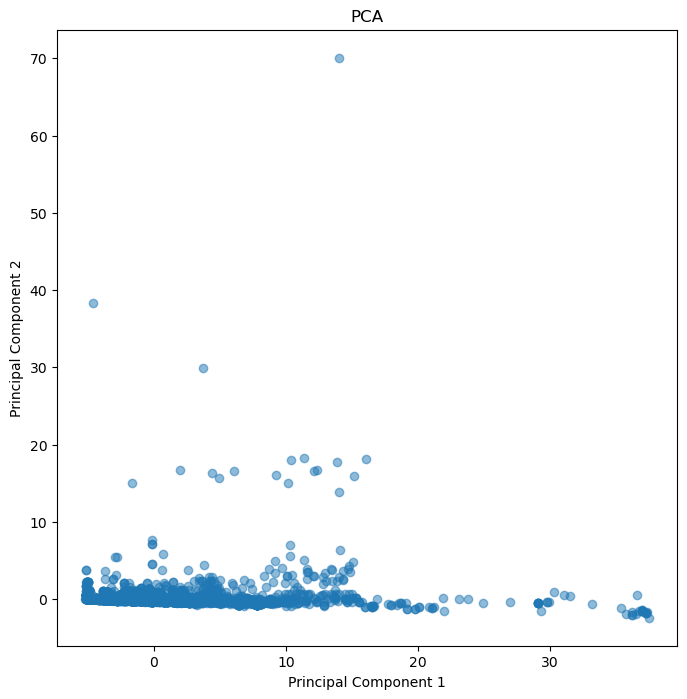

In [60]:
pca = PCA(n_components=2)
X = np.array(df['vector'].tolist())
X = StandardScaler().fit_transform(X)
principalComponents = pca.fit_transform(X)

#graficar
plt.figure(figsize=(8, 8))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')

plt.show()

Clusters: 25


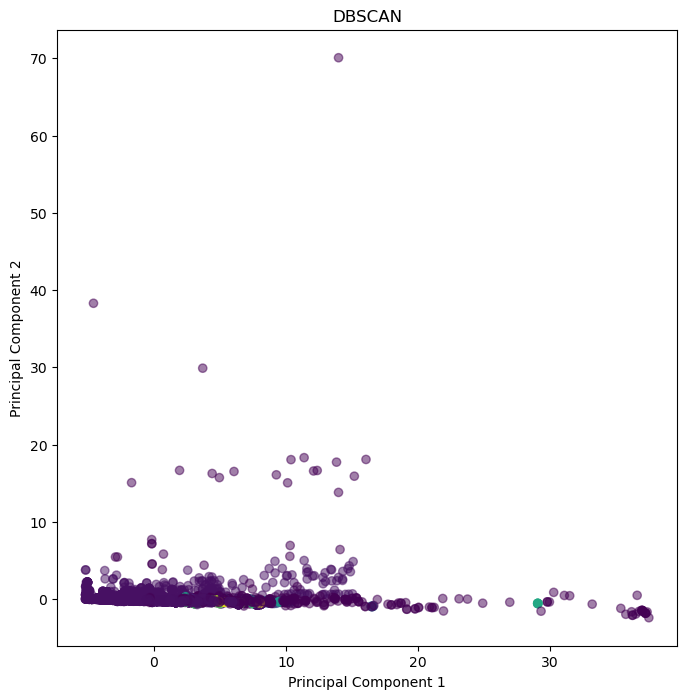

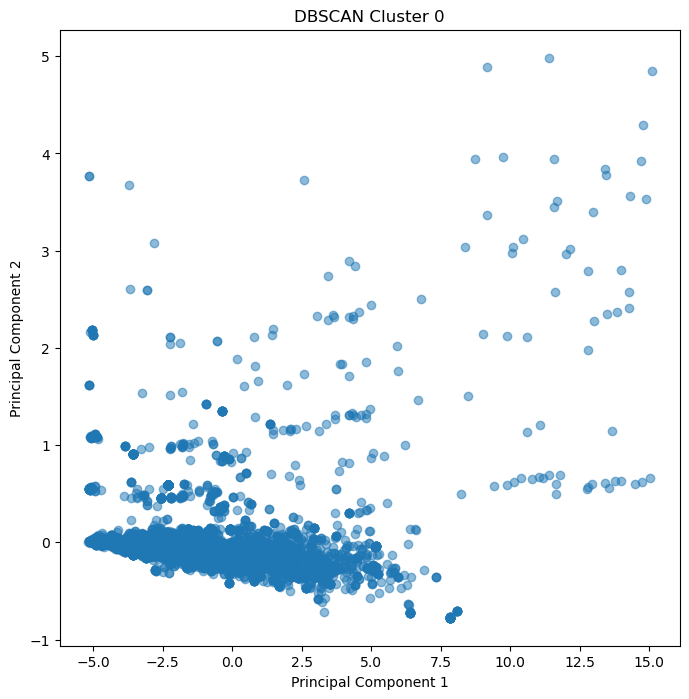

In [70]:
X = np.array(df['vector'].tolist())

X_scaled = StandardScaler().fit_transform(X)

dbscan = DBSCAN(eps=2.5, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

df['cluster'] = clusters

num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print("Clusters:", num_clusters)

#graficar por cluster
plt.figure(figsize=(8, 8))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=clusters, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN')

plt.show()

#graficar cluster 0
plt.figure(figsize=(8, 8))
plt.scatter(principalComponents[clusters == 0, 0], principalComponents[clusters == 0, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Cluster 0')

plt.show()

In [69]:
#imprimir dos secuencias del mismo cluster 
cluster = 0
df_cluster = df[df['cluster'] == cluster]
print(df_cluster.head()['sequence'])


0                                  MRLLAKIICLMLWAICVAE
1    LNRVVGGEDSTDSEWPWIVSIQKNGTHHCAGSLLTSRWVITAAHCF...
2    PPALAMPMPTEGTPPPLSGTPIPVPAYFRHAEPGFSLKRPRGLSRS...
4    DDQLLDDGKTLGECGFTSQTARPQAPATVGLAFRADDTFEALCIEP...
6    MRTLLPPALLTCWLLAPVNSIHPECRFHLEIQEEETKCAELLRSQT...
Name: sequence, dtype: object


### 3.2. K-means

In [43]:
X = np.array(df['vector'].tolist())

inertia = []
k_values = range(12, 400, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)


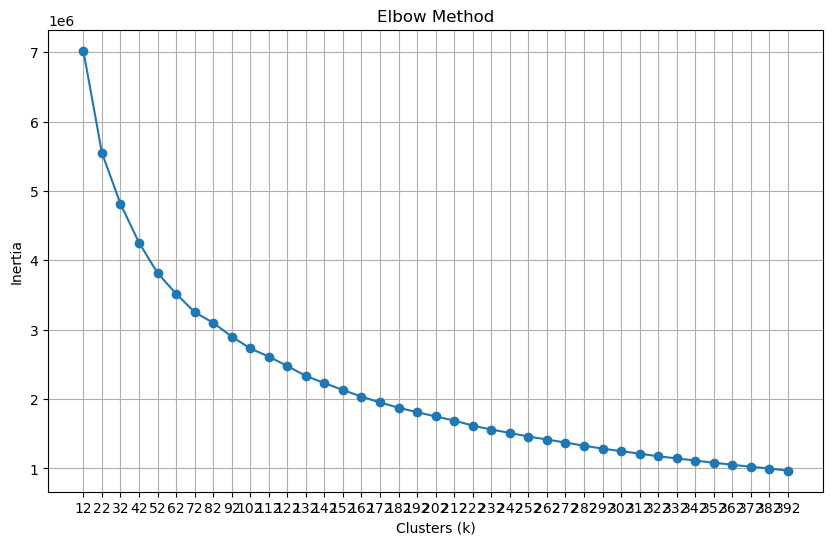

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

### 4. Analysis of results